In [1]:
import torch
import matplotlib.pyplot as plt
from polygon import RasLoss, SoftPolygon
from Loader_17 import DAVIS_Rawset
import json
from tenLoader import normalize
import torch.nn as nn
import torch.optim as optim
from MyLoss import get_edges, deviation_loss, total_len_loss
from preprocess_utensils import get_boundary_iou
import numpy as np
from tqdm import tqdm
import time
import math

In [2]:
train_rawset = DAVIS_Rawset(is_train=True)

In [3]:
val_rawset = DAVIS_Rawset(is_train=False)

In [4]:
len(train_rawset.data_set)

144

In [5]:
len(val_rawset.data_set)

61

In [26]:
class BoundarySampler(nn.Module):
    def __init__(
        self,
    ):
        super(BoundarySampler, self).__init__()
        self.boundary_points = nn.Parameter(
            torch.Tensor(
                [
                    [0.0, 0.0],
                    [0.0, 224.0],
                    [224.0, 224.0],
                    [224.0, 0.0],
                ]
            )
        )
        self.hard_polygon = SoftPolygon(0.01, mode="hard_mask")

    def forward(self):
        boundary = self.boundary_points
        boundary = torch.clamp(boundary, 0, 224)
        boundary = boundary.unsqueeze(0)
        return boundary
    
    def add_mid_points(self):
        # add mid points to the boundary
        boundary = self.boundary_points
        boundary_shift = torch.roll(boundary, 1, 0)
        # print(f"boundary: {boundary}")
        # print(f"boundary_shift: {boundary_shift}")
        mid_points = (boundary + boundary_shift) / 2
        # print(f"mid_points: {mid_points}")
        boundary_num = boundary.shape[0]
        new_boundary = torch.zeros(boundary_num * 2, 2).to(boundary.device)
        new_boundary[::2] = mid_points
        new_boundary[1::2] = boundary
        self.boundary_points = nn.Parameter(new_boundary)


    def get_numpy(self) -> np.ndarray:
        boundary = self.forward().squeeze(0).cpu().detach().numpy()
        return boundary

    def get_mask(self):
        boudary = self.forward()
        mask = self.hard_polygon(boudary, 224, 224)
        return mask.squeeze(0).cpu().detach().numpy()

In [159]:
boundary_sampler = BoundarySampler().cuda()

In [160]:
boundary_sampler.boundary_points

Parameter containing:
tensor([[  0.,   0.],
        [  0., 224.],
        [224., 224.],
        [224.,   0.]], device='cuda:0', requires_grad=True)

In [146]:
boundary_sampler.add_mid_points()

In [147]:
boundary_sampler.boundary_points.shape

torch.Size([256, 2])

IoU: 0.6679


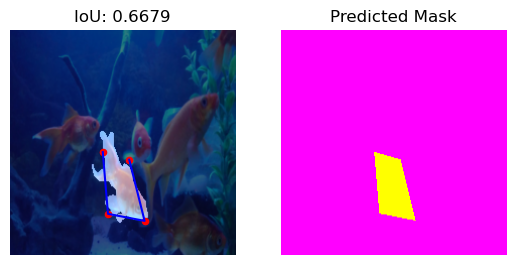

In [165]:
boundary = boundary_sampler.get_numpy()
boundary.shape, boundary
video_idx = 22
frame_idx = 0
img, mask = val_rawset.data_set[video_idx][frame_idx]
iou = get_boundary_iou(mask.cpu().detach().numpy(), boundary)
print(f"IoU: {iou:.4f}")
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(normalize(img).permute(1, 2, 0).cpu().numpy())
plt.axis("off")
plt.plot(
    boundary[:, 0],
    boundary[:, 1],
    "b-",
    # lw=5,
)
plt.scatter(
    boundary[:, 0],
    boundary[:, 1],
    c="r",
    s=20,
)
plt.imshow(
    mask.cpu().numpy(),
    alpha=0.5,
    cmap="gray",
)
plt.title(f"IoU: {iou:.4f}")
plt.subplot(1, 2, 2)
plt.imshow(
    boundary_sampler.get_mask(),
    cmap="spring",
    vmin=0,
    vmax=1,
)
plt.axis("off")
plt.title("Predicted Mask")
plt.show()

In [162]:
epoch_num = 100

In [163]:
loss_dict = {}
loss_dict["dif_loss"] = []
loss_dict["cos_loss"] = []
loss_dict["std_loss"] = []
loss_dict["len_loss"] = []
loss_dict["total_loss"] = []
ras_loss = RasLoss().cuda()
optimizer = optim.Adam(boundary_sampler.parameters(), lr=1e-0)
dif_weight = 0.5
std_weight = 0.5
# len_weight = 0.1
mask_batch = mask.unsqueeze(0).cuda()
for epoch in range(epoch_num):
    optimizer.zero_grad()
    boundary_points = boundary_sampler()
    dif_loss = ras_loss(boundary_points, mask_batch)
    std_loss = deviation_loss(boundary_points)
    len_loss = total_len_loss(boundary_points)
    if std_loss < 0.01:
        total_loss = dif_weight * dif_loss
    else:
        total_loss = dif_weight * dif_loss + std_weight * std_loss
    # if std_loss < 0.01:
    #     total_loss = dif_weight * dif_loss + len_weight * len_loss
    # else:
    #     total_loss = (
    #         dif_weight * dif_loss + std_weight * std_loss + len_weight * len_loss
    #     )
    loss_dict["dif_loss"].append(dif_loss.item())
    loss_dict["std_loss"].append(std_loss.item())
    loss_dict["len_loss"].append(len_loss.item())
    loss_dict["total_loss"].append(total_loss.item())
    # total_loss = boundary.mean()
    total_loss.backward()
    print(
        f"epoch: {epoch}, dif_loss: {dif_loss:.4f}, std_loss: {std_loss:.4f}, len_loss: {len_loss:.4f}, total_loss: {total_loss:.4f}",
    )
    optimizer.step()

epoch: 0, dif_loss: 0.9161, std_loss: 0.0000, len_loss: 1.0000, total_loss: 0.4581
epoch: 1, dif_loss: 0.9151, std_loss: 0.0000, len_loss: 0.9921, total_loss: 0.4575
epoch: 2, dif_loss: 0.9140, std_loss: 0.0000, len_loss: 0.9854, total_loss: 0.4570
epoch: 3, dif_loss: 0.9129, std_loss: 0.0000, len_loss: 0.9782, total_loss: 0.4565
epoch: 4, dif_loss: 0.9117, std_loss: 0.0000, len_loss: 0.9704, total_loss: 0.4558
epoch: 5, dif_loss: 0.9103, std_loss: 0.0000, len_loss: 0.9622, total_loss: 0.4551
epoch: 6, dif_loss: 0.9087, std_loss: 0.0000, len_loss: 0.9538, total_loss: 0.4544
epoch: 7, dif_loss: 0.9072, std_loss: 0.0000, len_loss: 0.9454, total_loss: 0.4536
epoch: 8, dif_loss: 0.9055, std_loss: 0.0000, len_loss: 0.9373, total_loss: 0.4528
epoch: 9, dif_loss: 0.9039, std_loss: 0.0000, len_loss: 0.9298, total_loss: 0.4519
epoch: 10, dif_loss: 0.9024, std_loss: 0.0000, len_loss: 0.9223, total_loss: 0.4512
epoch: 11, dif_loss: 0.9008, std_loss: 0.0000, len_loss: 0.9143, total_loss: 0.4504
ep

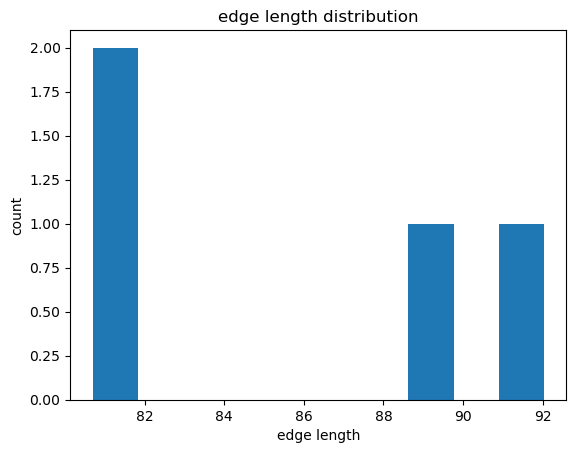

In [24]:
edges = get_edges(boundary_sampler())[0]
plt.hist(edges.cpu().detach().numpy(), bins=10)
plt.title("edge length distribution")
plt.xlabel("edge length")
plt.ylabel("count")
plt.show()

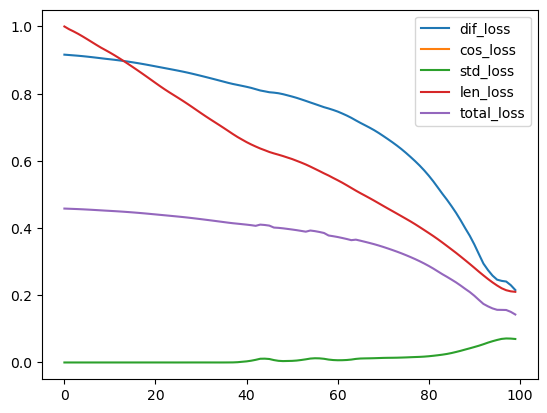

In [164]:
# plt the loss curve
plt.plot(loss_dict["dif_loss"], label="dif_loss")
plt.plot(loss_dict["cos_loss"], label="cos_loss")
plt.plot(loss_dict["std_loss"], label="std_loss")
plt.plot(loss_dict["len_loss"], label="len_loss")
plt.plot(loss_dict["total_loss"], label="total_loss")
plt.legend()

In [26]:
boundary_sampler.get_numpy().tolist()

[[74.4195785522461, 132.0005340576172],
 [76.60279083251953, 224.0],
 [157.63381958007812, 224.0],
 [155.05809020996094, 135.09295654296875]]

In [16]:
def sample_one_frame(
    mask: torch.Tensor,
    max_point_num: int,
    use_std_loss: bool,
    epoch_num=100,
) -> dict:
    boundary_sampler = BoundarySampler().cuda()
    results = {}
    mask_batch = mask.unsqueeze(0).cuda()
    current_point_num = boundary_sampler.boundary_points.shape[0]
    while current_point_num <= max_point_num:
        ras_loss = RasLoss().cuda()
        optimizer = optim.Adam(boundary_sampler.parameters(), lr=1e-0)
        if use_std_loss:
            dif_weight = 0.5
            std_weight = 0.5
        else:
            dif_weight = 1.0
            std_weight = 0.0
        for epoch in range(epoch_num):
            optimizer.zero_grad()
            boundary_points = boundary_sampler()
            dif_loss = ras_loss(boundary_points, mask_batch)
            std_loss = deviation_loss(boundary_points)
            if std_loss < 0.01:
                total_loss = dif_weight * dif_loss
            else:
                total_loss = dif_weight * dif_loss + std_weight * std_loss
            total_loss.backward()
            optimizer.step()
        iou = get_boundary_iou(
            mask.cpu().detach().numpy(), boundary_sampler.get_numpy()
        )
        current_result = {}
        current_result["boundary"] = boundary_sampler.get_numpy().tolist()
        current_result["iou"] = iou
        results[current_point_num] = current_result
        boundary_sampler.add_mid_points()
        current_point_num = boundary_sampler.boundary_points.shape[0]
    return results

# results = sample_one_frame(mask, 256, True)

In [28]:
results[4]["boundary"]

[[52.80258560180664, 99.69847106933594],
 [53.54964065551758, 224.0],
 [172.2995147705078, 224.0],
 [171.7554931640625, 99.68534851074219]]

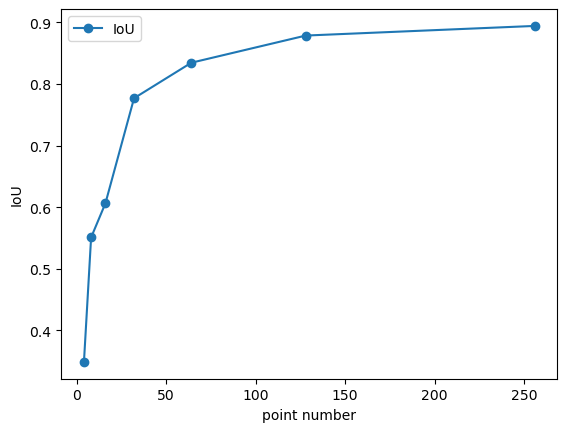

In [29]:
def plot_results(results: dict):
    point_num_list = list(results.keys())
    iou_list = [results[point_num]["iou"] for point_num in point_num_list]
    plt.plot(point_num_list, iou_list, label="IoU", marker="o")
    plt.xlabel("point number")
    plt.ylabel("IoU")
    plt.legend()
    plt.show()
plot_results(results)

In [30]:
tmp_boundary = boundary_sampler()
tmp_boundary.dtype


torch.float32

In [6]:
def show_result(img: torch.Tensor, mask: torch.Tensor, result: dict):
    boundary = result["boundary"]
    tensor_boundary = torch.tensor(boundary, dtype=torch.float32).unsqueeze(0).cuda()
    boundary = np.array(boundary)
    hard_polygon = SoftPolygon(0.01, mode="hard_mask").cuda()
    iou = result["iou"]
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(normalize(img).permute(1, 2, 0).cpu().numpy())
    plt.imshow(mask.cpu().numpy(), alpha=0.5, cmap="gray")
    plt.axis("off")
    plt.title("ground truth")
    plt.subplot(1, 3, 2)
    plt.imshow(normalize(img).permute(1, 2, 0).cpu().numpy())
    plt.axis("off")
    plt.plot(
        boundary[:, 0],
        boundary[:, 1],
        "b-",
        # lw=5,
    )
    plt.scatter(
        boundary[:, 0],
        boundary[:, 1],
        c="r",
        s=10,
    )
    plt.title(f"IoU: {iou:.4f}")
    plt.subplot(1, 3, 3)
    pred_mask = hard_polygon(tensor_boundary, 224, 224)
    pred_mask = pred_mask.squeeze(0).cpu().detach().numpy()
    plt.imshow(pred_mask, cmap="spring", vmin=0, vmax=1)
    plt.axis("off")
    plt.title("predicted mask")
    plt.show()


# show_result(img, mask, results[256])

In [18]:
def sample_one_video(
    video_data: list[tuple],
    max_point_num: int,
    use_std_loss: bool,
    epoch_num=100,
) -> dict:
    results = []
    for img, mask in tqdm(video_data):
    # for img, mask in video_data:
        result = sample_one_frame(mask, max_point_num, use_std_loss, epoch_num)
        results.append(result)
    return results


# video_results = sample_one_video(train_rawset.data_set[0], 256, True)

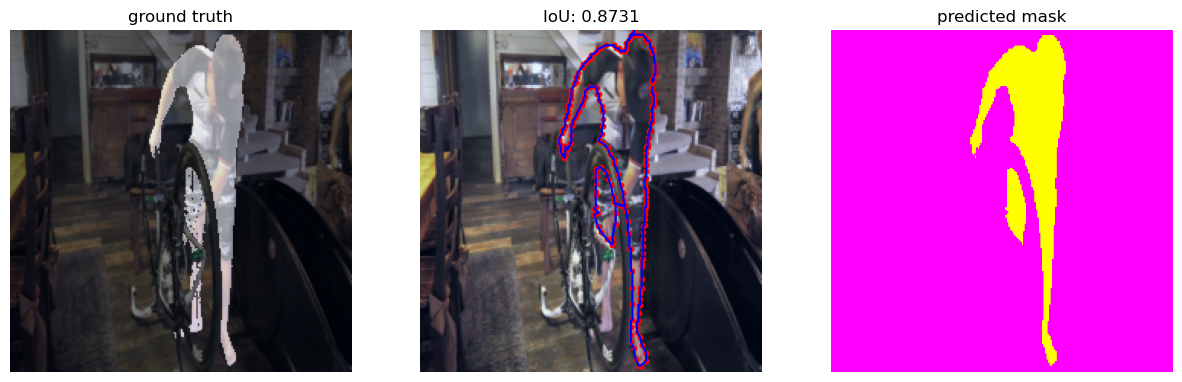

In [606]:
frame_idx = 60
# show_result(val_rawset.data_set[0][frame_idx][0], val_rawset.data_set[0][frame_idx][1], video_results[frame_idx][256])

In [55]:
def sample_save_dataset(
    video_dataset: list,
    start_idx: int,
    save_title: str,
    max_point_num: int,
    use_std_loss: bool,
    epoch_num=100,
):
    save_path = f"{save_title}_{start_idx}_{max_point_num}_{"std" if use_std_loss else ""}_{epoch_num}.json"
    results = []
    for video_data in video_dataset:
        result = sample_one_video(video_data, max_point_num, use_std_loss, epoch_num)
        results.append(result)
    with open(save_path, "w") as f:
        json.dump(results, f, )
sample_save_dataset(val_rawset.data_set[1:2], 1, "val", 256, True, 100)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 69/69 [05:35<00:00,  4.86s/it]


In [7]:
# load the saved results
def load_results(
    start_idx: int,
    save_title: str,
    max_point_num: int,
    use_std_loss: bool,
    epoch_num=100,
    fir_epoch_multi=None,
):
    save_path = f"{save_title}_{start_idx}_{max_point_num}_{"std" if use_std_loss else ""}_{epoch_num}.json"
    if fir_epoch_multi is not None:
        save_path = f"{save_title}_{start_idx}_{max_point_num}_{"std" if use_std_loss else ""}_{epoch_num}_{fir_epoch_multi}.json"
    with open(save_path, "r") as f:
        results = json.load(f)

    def numericalize_dict(d: dict):
        result = {}
        for key, value in d.items():
            result[int(key)] = value
        return result

    # numericalize the results
    for video_result in results:
        for frame_idx, frame_result in enumerate(video_result):
            video_result[frame_idx] = numericalize_dict(frame_result)

    return results


results = load_results(1, "val", 256, True, 100)

In [77]:
len(results[0][0][128]["boundary"])

128

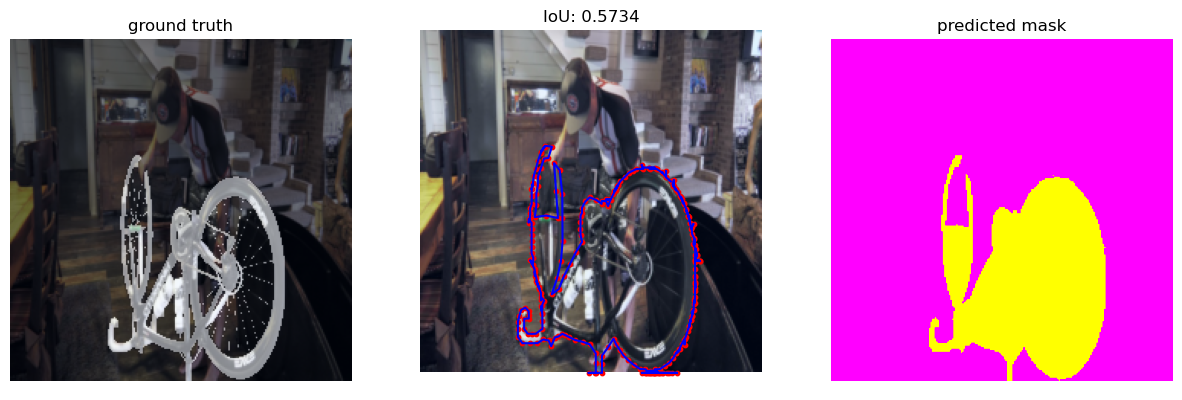

In [75]:
frame_idx = 20
show_result(val_rawset.data_set[1][frame_idx][0], val_rawset.data_set[1][frame_idx][1], results[0][frame_idx][256])

In [ ]:
# sample the validation dataset
sample_save_dataset(val_rawset.data_set, 0, "val", 256, True, 100)
# sample the first half of the training dataset
sample_save_dataset(
    train_rawset.data_set[: len(train_rawset.data_set) // 2], 0, "train", 256, True, 100
)
# sample the second half of the training dataset
sample_save_dataset(
    train_rawset.data_set[len(train_rawset.data_set) // 2 :],
    len(train_rawset.data_set) // 2,
    "train",
    256,
    True,
    100,
)

In [8]:
old_val_sample_set = load_results(
    0,
    "val",
    256,
    True,
    100,
)
old_train_sample_set_first_half = load_results(
    0,
    "train",
    256,
    True,
    100,
)
old_train_sample_set_second_half = load_results(
    len(train_rawset.data_set) // 2,
    "train",
    256,
    True,
    100,
)
old_train_sample_set = (
    old_train_sample_set_first_half + old_train_sample_set_second_half
)

In [9]:
val_sample_set = load_results(
    0,
    "val",
    256,
    True,
    100,
    5,
)

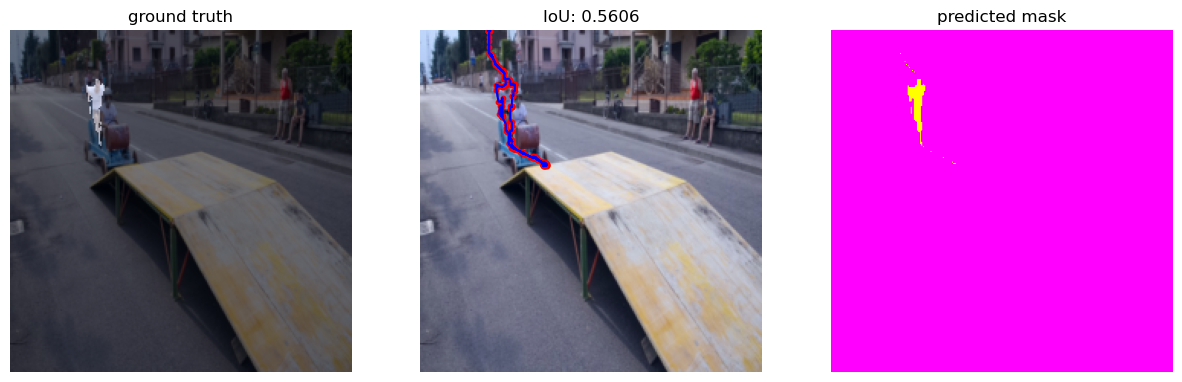

In [23]:
video_idx = 60
frame_idx = 10
show_result(
    val_rawset.data_set[video_idx][frame_idx][0],
    val_rawset.data_set[video_idx][frame_idx][1],
    val_sample_set[video_idx][frame_idx][256],
)

In [11]:
train_sample_set_fir_half = load_results(
    0,
    "train",
    256,
    True,
    100,
    5,
)
train_sample_set_sec_half = load_results(
    len(train_rawset.data_set) // 2,
    "train",
    256,
    True,
    100,
    5,
)

In [12]:
train_sample_set = train_sample_set_fir_half + train_sample_set_sec_half

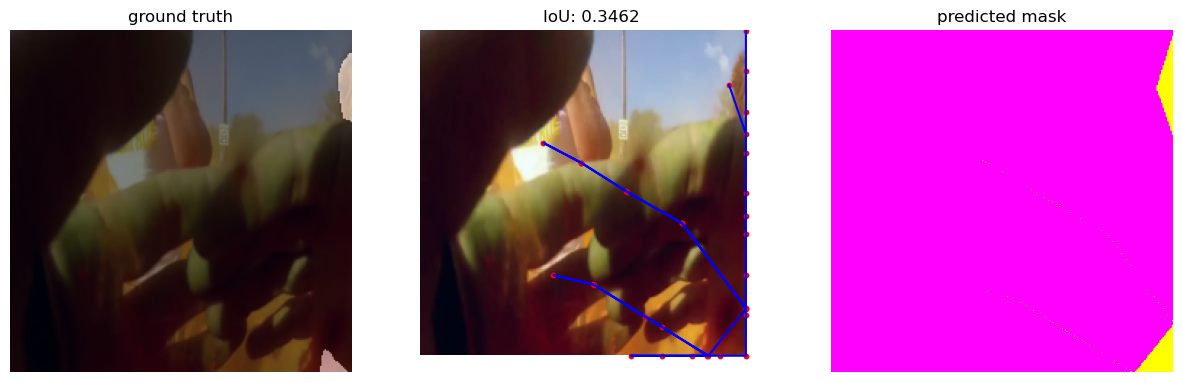

In [32]:
video_idx = 16
frame_idx = 47
point_num = 32
show_result(
    train_rawset.data_set[video_idx][frame_idx][0],
    train_rawset.data_set[video_idx][frame_idx][1],
    train_sample_set[video_idx][frame_idx][point_num],
)

In [46]:
def get_average_iou(sample_set: list, point_num: int) -> float:
    iou_list = []
    for video_result in sample_set:
        for frame_result in video_result:
            iou_list.append(frame_result[point_num]["iou"])
    return np.mean(iou_list)
get_average_iou(val_sample_set, 16)

0.7722681781684665

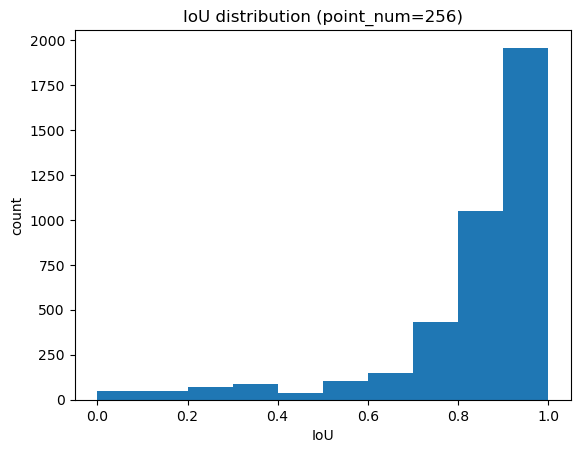

In [203]:
def show_iou_distribution(sample_set: list, point_num: int):
    iou_list = []
    for video_result in sample_set:
        for frame_result in video_result:
            iou_list.append(frame_result[point_num]["iou"])
    plt.hist(iou_list, bins=10)
    plt.title("IoU distribution (point_num=256)")
    plt.xlabel("IoU")
    plt.ylabel("count")
    plt.show()
show_iou_distribution(val_sample_set, 256)

In [179]:
def find_the_low_iou_frame(sample_set: list, point_num: int, threshold: float):
    low_iou_frames = []
    for video_idx, video_result in enumerate(sample_set):
        for frame_idx, frame_result in enumerate(video_result):
            if frame_result[point_num]["iou"] < threshold:
                low_iou_frames.append((video_idx, frame_idx))
    return low_iou_frames
find_the_low_iou_frame(train_sample_set, 256, 0.1)

[(2, 38),
 (2, 39),
 (2, 40),
 (2, 50),
 (2, 57),
 (2, 61),
 (13, 62),
 (27, 29),
 (27, 47),
 (27, 63),
 (29, 72),
 (29, 73),
 (29, 74),
 (29, 78),
 (29, 79),
 (29, 80),
 (32, 69),
 (32, 70),
 (32, 71),
 (32, 72),
 (32, 73),
 (32, 74),
 (32, 75),
 (32, 76),
 (32, 77),
 (32, 78),
 (32, 79),
 (33, 8),
 (39, 7),
 (39, 8),
 (40, 17),
 (49, 0),
 (49, 1),
 (49, 2),
 (49, 3),
 (49, 4),
 (49, 5),
 (49, 6),
 (49, 7),
 (49, 8),
 (49, 9),
 (49, 10),
 (49, 11),
 (49, 12),
 (49, 13),
 (49, 14),
 (49, 15),
 (49, 16),
 (49, 17),
 (49, 18),
 (49, 19),
 (49, 20),
 (49, 21),
 (49, 22),
 (49, 23),
 (49, 24),
 (49, 25),
 (49, 26),
 (49, 27),
 (49, 28),
 (49, 29),
 (49, 30),
 (49, 31),
 (49, 32),
 (49, 33),
 (49, 34),
 (49, 35),
 (49, 36),
 (49, 37),
 (49, 38),
 (49, 39),
 (49, 40),
 (49, 41),
 (49, 42),
 (49, 43),
 (49, 44),
 (49, 45),
 (49, 46),
 (49, 47),
 (49, 48),
 (49, 49),
 (49, 50),
 (49, 51),
 (49, 52),
 (49, 53),
 (49, 58),
 (49, 59),
 (49, 60),
 (49, 61),
 (49, 63),
 (49, 64),
 (49, 65),
 (55, 6

In [24]:
def find_range_iou_frame(sample_set: list, point_num: int, low_threshold: float, high_threshold: float):
    range_iou_frames = []
    for video_idx, video_result in enumerate(sample_set):
        for frame_idx, frame_result in enumerate(video_result):
            iou = frame_result[point_num]["iou"]
            if iou < high_threshold and iou > low_threshold:
                range_iou_frames.append((video_idx, frame_idx))
    return range_iou_frames
find_range_iou_frame(train_sample_set, 256, 0.56, 0.561)

[(6, 71), (16, 47), (29, 82), (30, 7), (47, 15), (76, 1), (97, 62)]

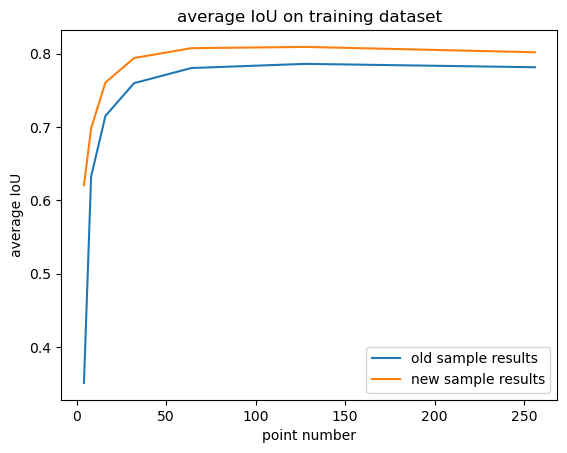

In [200]:
def compare_two_iou_curve(
    sample_set1: list,
    sample_set2: list,
    point_num: int,
    title: str,
):
    point_num_list = list(sample_set1[0][0].keys())
    iou_list1 = [get_average_iou(sample_set1, point_num) for point_num in point_num_list]
    iou_list2 = [get_average_iou(sample_set2, point_num) for point_num in point_num_list]
    plt.plot(point_num_list, iou_list1, label=f"old sample results")
    plt.plot(point_num_list, iou_list2, label=f"new sample results")
    plt.xlabel("point number")
    plt.ylabel("average IoU")
    plt.legend()
    plt.title(f"average IoU on {title}")
    plt.show()
compare_two_iou_curve(old_train_sample_set, train_sample_set, 256, "training dataset")

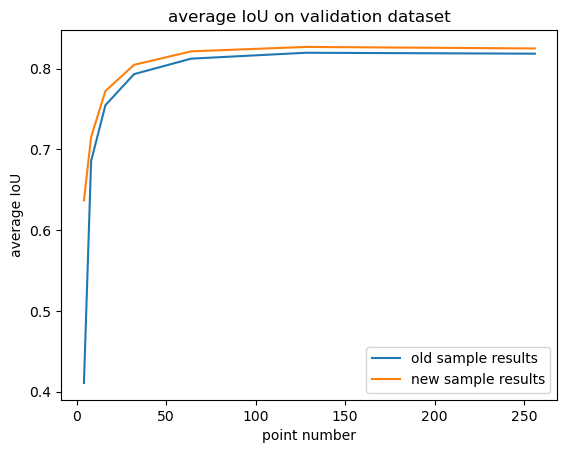

In [201]:
compare_two_iou_curve(old_val_sample_set, val_sample_set, 256, "validation dataset")

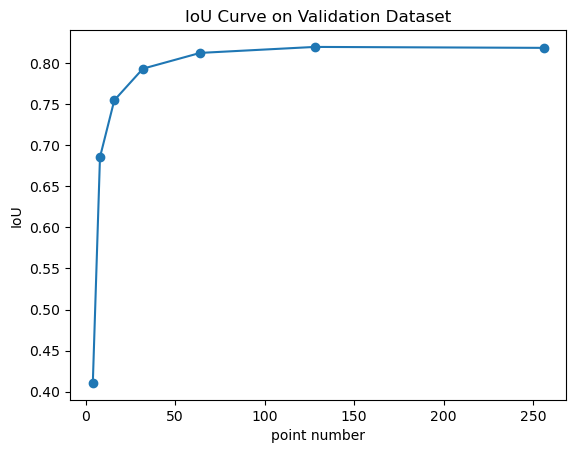

In [157]:
def plot_iou_curve(sample_set: list, title: str):
    point_num_list = [4, 8, 16, 32, 64, 128, 256]
    iou_list = [get_average_iou(sample_set, point_num) for point_num in point_num_list]
    plt.plot(point_num_list, iou_list, marker="o")
    plt.xlabel("point number")
    plt.ylabel("IoU")
    plt.title(title)
    plt.show()
plot_iou_curve(val_sample_set, "IoU Curve on Validation Dataset")

In [223]:
%load_ext autoreload
%autoreload 2